# Import libraries and system checks

In [3]:
!pip list

Package            Version
------------------ -----------
aiohttp            3.9.5
aiosignal          1.2.0
asttokens          2.4.1
attrs              23.1.0
Bottleneck         1.3.7
Brotli             1.0.9
certifi            2024.6.2
charset-normalizer 2.0.4
colorama           0.4.6
comm               0.2.2
contourpy          1.2.0
cycler             0.11.0
datasets           2.19.1
debugpy            1.6.7
decorator          5.1.1
dill               0.3.8
exceptiongroup     1.2.0
executing          2.0.1
filelock           3.13.1
fonttools          4.51.0
frozenlist         1.4.0
fsspec             2024.3.1
huggingface_hub    0.23.1
idna               3.7
importlib_metadata 7.1.0
ipykernel          6.29.4
ipython            8.25.0
jedi               0.19.1
Jinja2             3.1.4
jupyter_client     8.6.2
jupyter_core       5.7.2
kiwisolver         1.4.4
MarkupSafe         2.1.3
matplotlib         3.8.4
matplotlib-inline  0.1.7
mkl-fft            1.3.8
mkl-random         1.2.4
mkl-

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader
import pickle
import time

c:\Users\datbi\anaconda3\envs\thesis-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if CUDA is available
print(torch.cuda.is_available())

True


# Load redudancy scores from pickle and construct redudancy DF

In [8]:
# Load pickle file with redundancies
import pickle

with open('C:/Users/datbi/Downloads/uva-thesis-v2/uva-thesis/main_github/boolq_cosine_sim_BERT_1000.pkl', 'rb') as file:
    boolq_cosine_sim_ft = pickle.load(file)

# Return average redundancies
average_redundancies = [sum(values) / len(values) for values in zip(*boolq_cosine_sim_ft)]

# Structure for storing (head1, head2, similarity)
num_heads = 144
test_store = []
avg_idx = 0
for i in range(num_heads):
    for j in range(i+1, num_heads):
      test_store.append([i+1, j+1, average_redundancies[avg_idx]])
      avg_idx +=  1
        

# Dataframe that stores every head vs every other head for analysis

# Create matrix with all pairs for analysis
original_corr_df = pd.DataFrame(test_store, columns=['head_a', 'head_b', 'similarity'])
double_corr_df = pd.DataFrame(test_store, columns=['head_a', 'head_b', 'similarity'])
reverse_corr_df = double_corr_df[['head_b', 'head_a', 'similarity']].copy()
reverse_corr_df = reverse_corr_df.rename(columns={'head_b': 'head_a', 'head_a': 'head_b'})

all_pairs_corr = pd.concat([original_corr_df, reverse_corr_df], axis=0)
#all_pairs_corr['head_a'] = all_pairs_corr['head_a'].apply(str)

## Order head by redundancy scores against all other heads

In [9]:
sorted_avg_corr = all_pairs_corr.groupby('head_a').mean().sort_values(by='similarity', ascending=False)

# Helper functions

## Dictionary that stores the heads with its corresponding layer index and head index

In [10]:
# Create dictionary with any number of heads and layers
def get_layers_heads(heads_each_layer, layers_total):
    values_layers_heads = {}
    total_heads = heads_each_layer * layers_total
    
    for head in np.arange(1, total_heads+1):
        layer = (head - 1) // layers_total + 1
        if layer == 1:
            values_layers_heads[head] = (layer, head)
        else:
            head_in_layer = head - (layers_total * (layer - 1))
            values_layers_heads[head] = (layer, head_in_layer)
        
    return values_layers_heads

## Get exact heads to prune at each interval

In [11]:
def get_heads_to_prune(redundant_heads):
    # Input is heads ordered by redundancy
    prune_ratios = np.arange(0.05, 0.96, 0.05)
    number_of_heads = len(redundant_heads)
    heads_to_prune_interval = []
    
    for ratio in prune_ratios:
        num_heads_to_prune = round(number_of_heads * ratio)
        heads_to_prune_interval.append(redundant_heads[:num_heads_to_prune])
    
    return heads_to_prune_interval

## Batch the data for DataLoader

In [12]:
def collate_fn(batch):
    # Prepare the batch for DataLoader
    input_ids = torch.stack([torch.tensor(d['input_ids']) for d in batch])
    attention_mask = torch.stack([torch.tensor(d['attention_mask']) for d in batch])
    token_type_ids = torch.stack([torch.tensor(d['token_type_ids']) for d in batch])
    labels = torch.tensor([d['labels'] for d in batch])
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'token_type_ids': token_type_ids,
        'labels': labels
    }

# Load validation set

## Load model link and tokenizer

In [13]:
# Model link and tokenizer
model_link = "rycecorn/bert-fine-tuned-boolq"
tokenizer = AutoTokenizer.from_pretrained(model_link)

c:\Users\datbi\anaconda3\envs\thesis-env\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\datbi\.cache\huggingface\hub\models--rycecorn--bert-fine-tuned-boolq. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [9]:
%%time
# Dataset prep
from datasets import load_dataset
dataset = load_dataset("boolq")

def preprocess_function(batch):
    # Tokenize the batch of questions and passages
    tokenized_data = tokenizer(batch["question"], batch["passage"],
                               truncation=True, padding="max_length", max_length=512)

    # Create labels for the entire batch
    tokenized_data['labels'] = [1 if answer else 0 for answer in batch['answer']]
    return tokenized_data

# Apply the function to the dataset in batches
tokenized_datasets = dataset.map(preprocess_function, batched=True)
validation_set = tokenized_datasets['validation']
validation_loader = DataLoader(validation_set, batch_size=16, collate_fn=collate_fn)

CPU times: user 470 ms, sys: 83.7 ms, total: 554 ms
Wall time: 6.28 s


In [10]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'passage', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['question', 'answer', 'passage', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3270
    })
})

# Create layer and head index dictionary

In [11]:
model = AutoModelForSequenceClassification.from_pretrained(model_link)
layers = len(model.bert.encoder.layer)
heads_each_layer = model.config.num_attention_heads

values_layers_heads = get_layers_heads(heads_each_layer, layers)

print(f"The model has {layers} layers with {heads_each_layer} heads in each layer")

The model has 12 layers with 12 heads in each layer


# Set pruning conditions

In [12]:
# Storing the heads to prune
heads_in_order = sorted_avg_corr.index.tolist()
pruning_interval_heads = get_heads_to_prune(heads_in_order)

# Pruning ratios
prune_percentage = np.arange(0.05, 0.96, 0.05)

# Creates dictionary of the interval and heads to be pruned for that interval. Has format {'prune_ratio' : [heads_to_be_pruned]}
prune_dict = {}
i = 0
for percentage in prune_percentage:
    prune_dict[round(percentage, 2)] = pruning_interval_heads[i]
    i += 1
    
print(f"Pruning ratios are {prune_percentage}")

Pruning ratios are [0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]


In [13]:
#pruning_interval_heads[-1]

## Heads at each interval for plotting

In [14]:
def extract_new_items(lists):
    result = [pruning_interval_heads[0]]
    for i in range(1, len(lists)):
        previous_list = lists[i - 1]
        current_list = lists[i]
        new_items = [item for item in current_list if item not in previous_list]
        result.append(new_items)
    return result

In [15]:
new_heads_each_interval = extract_new_items(pruning_interval_heads)
prune_percentage = np.around(np.arange(0.05, 0.96, 0.05), 2)
dict_new_heads_each_interval = {}
for i in range(0, len(prune_percentage)):
    dict_new_heads_each_interval[prune_percentage[i]] = new_heads_each_interval[i]

dict_new_heads_each_interval

{0.05: [38, 44, 43, 41, 45, 65, 39],
 0.1: [51, 81, 143, 142, 137, 133, 141],
 0.15: [136, 135, 138, 140, 139, 134, 144, 50],
 0.2: [53, 96, 66, 126, 92, 55, 58],
 0.25: [91, 80, 132, 57, 69, 72, 52],
 0.3: [83, 131, 76, 123, 122, 47, 73],
 0.35: [88, 37, 49, 56, 74, 64, 61],
 0.4: [67, 128, 103, 130, 75, 87, 22, 121],
 0.45: [124, 127, 59, 109, 63, 54, 28],
 0.5: [82, 62, 68, 125, 95, 8, 21],
 0.55: [129, 13, 78, 31, 116, 112, 94],
 0.6: [99, 115, 27, 5, 1, 10, 86],
 0.65: [7, 97, 29, 40, 60, 79, 100, 32],
 0.7: [35, 102, 70, 84, 6, 93, 2],
 0.75: [18, 33, 24, 15, 77, 90, 20],
 0.8: [101, 36, 48, 89, 12, 119, 114],
 0.85: [98, 30, 16, 85, 110, 71, 26],
 0.9: [9, 118, 117, 104, 23, 106, 108, 46],
 0.95: [113, 120, 105, 3, 111, 11, 14]}

In [16]:
with open('BoolQ_BERT_prune_interval.pkl', 'wb') as f:
    pickle.dump(dict_new_heads_each_interval, f)

# Main pruning process

In [17]:
from tqdm import tqdm

In [18]:
pruning_results = []

In [19]:
'''%%time

import time

# Model specific data
num_attention_heads = model.config.num_attention_heads
head_size = model.config.hidden_size // num_attention_heads

# PRUNING PROCESS
for prune_ratio in tqdm(prune_percentage, desc='Pruning ratios'):
    # Load and reset model
    model = AutoModelForSequenceClassification.from_pretrained(model_link)
    heads_prune_this_iteration = prune_dict[round(prune_ratio ,2)]
    
    # This prunes each head in the respectie pruning ratio
    for head_to_prune in heads_prune_this_iteration:
        layer_index = values_layers_heads[head_to_prune][0] - 1
        head_index = values_layers_heads[head_to_prune][1] - 1

        ## Zero out the specific head in the query, key, and value matrices
        ### Zero query matrix
        model.bert.encoder.layer[layer_index].attention.self.query.weight.data[:, head_index * head_size:(head_index + 1) * head_size] = 0
        model.bert.encoder.layer[layer_index].attention.self.query.bias.data[head_index * head_size:(head_index + 1) * head_size] = 0
        ### Zero key matrix
        model.bert.encoder.layer[layer_index].attention.self.key.weight.data[:, head_index * head_size:(head_index + 1) * head_size] = 0
        model.bert.encoder.layer[layer_index].attention.self.key.bias.data[head_index * head_size:(head_index + 1) * head_size] = 0
        ### Zero value matrix
        model.bert.encoder.layer[layer_index].attention.self.value.weight.data[:, head_index * head_size:(head_index + 1) * head_size] = 0
        model.bert.encoder.layer[layer_index].attention.self.value.bias.data[head_index * head_size:(head_index + 1) * head_size] = 0
        
    # Evaluate the pruned model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Evaluation mode
    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    final_comp_time = 0

    for batch in validation_loader:
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_token_type_ids = batch['token_type_ids'].to(device)
        b_labels = batch['labels'].to(device)
        
        start_time = time.time()
        with torch.no_grad():
            # Perform a forward pass
            outputs = model(b_input_ids, 
                            token_type_ids=b_token_type_ids, 
                            attention_mask=b_attention_mask,
                            labels=b_labels)

        # Calculate the loss
        loss = outputs.loss
        total_eval_loss += loss.item()

        # Get the predictions
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        # time algorithm
        end_time = time.time()
        final_comp_time += end_time - start_time
        # Calculate accuracy
        accuracy = (predictions == b_labels).cpu().numpy().mean()
        total_eval_accuracy += accuracy
    
    # Calculate the average loss and accuracy for the pruned model
    avg_val_accuracy = total_eval_accuracy / len(validation_loader)
    avg_val_loss = total_eval_loss / len(validation_loader)
    
    # Append to storage
    pruning_results.append((round(prune_ratio, 2), len(heads_prune_this_iteration), avg_val_accuracy, final_comp_time))
'''

"%%time\n\nimport time\n\n# Model specific data\nnum_attention_heads = model.config.num_attention_heads\nhead_size = model.config.hidden_size // num_attention_heads\n\n# PRUNING PROCESS\nfor prune_ratio in tqdm(prune_percentage, desc='Pruning ratios'):\n    # Load and reset model\n    model = AutoModelForSequenceClassification.from_pretrained(model_link)\n    heads_prune_this_iteration = prune_dict[round(prune_ratio ,2)]\n    \n    # This prunes each head in the respectie pruning ratio\n    for head_to_prune in heads_prune_this_iteration:\n        layer_index = values_layers_heads[head_to_prune][0] - 1\n        head_index = values_layers_heads[head_to_prune][1] - 1\n\n        ## Zero out the specific head in the query, key, and value matrices\n        ### Zero query matrix\n        model.bert.encoder.layer[layer_index].attention.self.query.weight.data[:, head_index * head_size:(head_index + 1) * head_size] = 0\n        model.bert.encoder.layer[layer_index].attention.self.query.bias.dat

In [20]:
import time
from tqdm import tqdm
import torch
from transformers import AutoModelForSequenceClassification

# Model specific data
num_attention_heads = model.config.num_attention_heads
head_size = model.config.hidden_size // num_attention_heads

def prune_heads(model, heads_to_prune, head_size):
    for head_to_prune in heads_to_prune:
        layer_index = values_layers_heads[head_to_prune][0] - 1
        head_index = values_layers_heads[head_to_prune][1] - 1

        # Zero out the specific head in the query, key, and value matrices
        for matrix in ['query', 'key', 'value']:
            weight = getattr(model.bert.encoder.layer[layer_index].attention.self, matrix).weight.data
            bias = getattr(model.bert.encoder.layer[layer_index].attention.self, matrix).bias.data
            weight[:, head_index * head_size:(head_index + 1) * head_size] = 0
            bias[head_index * head_size:(head_index + 1) * head_size] = 0

def evaluate_model(model, validation_loader, device):
    model.to(device)
    model.eval()
    
    total_eval_accuracy = 0
    total_eval_loss = 0
    final_comp_time = 0

    for batch in validation_loader:
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_token_type_ids = batch['token_type_ids'].to(device)
        b_labels = batch['labels'].to(device)
        
        start_time = time.time()
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=b_token_type_ids, attention_mask=b_attention_mask, labels=b_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        end_time = time.time()
        final_comp_time += end_time - start_time
        accuracy = (predictions == b_labels).cpu().numpy().mean()
        total_eval_accuracy += accuracy

    avg_val_accuracy = total_eval_accuracy / len(validation_loader)
    avg_val_loss = total_eval_loss / len(validation_loader)
    
    return avg_val_accuracy, avg_val_loss, final_comp_time

# Main loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pruning_results = []

# Load and save the initial state of the model
initial_model = AutoModelForSequenceClassification.from_pretrained(model_link)
initial_state_dict = initial_model.state_dict()

for prune_ratio in tqdm(prune_percentage, desc='Pruning ratios'):
    # Load the initial state of the model
    model.load_state_dict(initial_state_dict)
    
    heads_prune_this_iteration = prune_dict[round(prune_ratio, 2)]
    prune_heads(model, heads_prune_this_iteration, head_size)
    
    avg_val_accuracy, avg_val_loss, final_comp_time = evaluate_model(model, validation_loader, device)
    
    pruning_results.append((round(prune_ratio, 2), len(heads_prune_this_iteration), avg_val_accuracy, final_comp_time))


Pruning ratios: 100%|██████████| 19/19 [10:02<00:00, 31.69s/it]


In [21]:
# Case where no heads are pruned
# Load and save the initial state of the model
initial_model = AutoModelForSequenceClassification.from_pretrained(model_link)
initial_state_dict = initial_model.state_dict()

# Evaluate the base case where no heads are pruned
model.load_state_dict(initial_state_dict)
base_accuracy, base_loss, base_comp_time = evaluate_model(model, validation_loader, device)

print(f"Base accuracy: {base_accuracy}")
print(f"Base inference time: {base_comp_time}")

Base accuracy: 0.7489837398373983
Base inference tie: 29.08620309829712


In [22]:
pruning_df = pd.DataFrame(pruning_results, columns=['Pruning ratio', 'Num heads pruned', 'Average validation accuracy', 'Comp time'])

In [23]:
pruning_df

,Pruning ratio,Num heads pruned,Average validation accuracy,Comp time
0,0.05,7,0.750407,31.383663
1,0.10,14,0.749492,29.259278
2,0.15,22,0.745020,29.384397
3,0.20,29,0.724085,29.474767
4,0.25,36,0.707012,29.520971
5,0.30,43,0.689329,29.567274
6,0.35,50,0.679472,29.595579
7,0.40,58,0.587805,29.595457
8,0.45,65,0.532520,29.591908
9,0.50,72,0.484045,29.568115


In [24]:
# Save to CSV
pruning_df.to_csv('boolq_prune_df.csv', index=False)

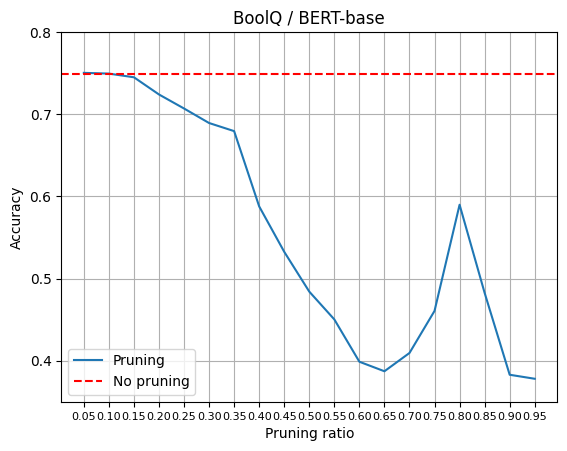

In [55]:
x = pruning_df['Pruning ratio']

plt.plot(x, pruning_df['Average validation accuracy'], label='Pruning')
plt.title('BoolQ / BERT-base')
plt.xlabel('Pruning ratio', fontsize=10)
plt.ylabel('Accuracy')
plt.xticks(np.arange(start=0.05, stop= 1, step=0.05), fontsize=8)
plt.axhline(0.7489, color='r', linestyle='--', label='No pruning')
plt.grid(True)
plt.ylim(0.35, 0.8)
plt.legend()
#plt.savefig('prune_boolq_BERT-FT.png')
plt.show()